## Predicting Employee Turnover:

### Question: Can we predict the likelihood of an employee leaving within the next year based on current hiring and turnover rates?

#### Approach: Use logistic regression to model the probability of turnover (rolling_12month_to_percent) as a function of various factors like external openings, internal openings, terms, and new hires (ms_recap, turnover_recap).

## To achieve the analysis, I will follow 5 Steps 

### 1. Data Preparation:
Merge the ms_recap, turnover_recap, and rolling_12_month_to_percent datasets on Plant # to create a single dataset for analysis.
Ensure that the data types are appropriate for each column, particularly the date and numerical columns.

### 2. Feature Engineering:
Create a binary target variable, high_turnover, that indicates whether a plant has a higher than median turnover rate (1 for high turnover, 0 for low turnover).
Select relevant features that might influence turnover, such as External Openings, Internal Openings, Pending BG/DS, Filled by Temps, and new hire terms from different fiscal years.

### 3. Exploratory Data Analysis:
Examine the distributions of the features and target variable.
Look for correlations between features and the target variable to understand the relationships better.

### 4. Model Building:
Split the combined data into training and testing sets to evaluate the performance of the predictive model.
Use logistic regression to model the probability of high turnover. Logistic regression is suitable for binary classification tasks and will allow us to estimate the odds of high turnover based on the selected features.

### 5. Interpretation and Conclusion:
Draw conclusions from the model results regarding the factors that are most predictive of high turnover.
Provide recommendations for actionable strategies that could be employed to reduce turnover based on the model's findings.

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pyrsm as rsm



# 1. Data Preparation
#### Load/read the data
- Reading "MS Recap", "Turnover Recap", and "Rolling 12 month to %" data set

In [47]:
import pandas as pd

ms_recap = pd.ExcelFile('ms_recap.xlsx')
ms_recap = ms_recap.parse('Sheet1')

turnover_recap = pd.ExcelFile('turnover_recap.xlsx')
turnover_recap = turnover_recap.parse('Sheet1')

rolling_12_month_to_percent = pd.ExcelFile('rolling_12_month_to_percent.xlsx')
rolling_12_month_to_percent = rolling_12_month_to_percent.parse('Sheet1')


In [48]:
ms_recap

,Report Date,Plant #,Plant Name,Department,External Openings,Internal Openings,Pending BG/DS,Filled by Temps
0,2023-04-11,43,Birmingham,Production,31,0,6,12
1,2023-04-11,34,Albert Lea,Production,8,1,1,0
2,2023-04-11,86,Port St. Lucie,Production,0,0,0,0
3,2023-04-11,10,Opelousas,Production,0,0,0,0
4,2023-04-11,33,Waukesha,Production,0,0,0,0
...,...,...,...,...,...,...,...,...
3127,2024-01-23,75,Ontario,QA,2,0,1,0
3128,2024-01-23,60,Ft. Worth,QA,0,0,0,4
3129,2024-01-23,25,Chambersburg,QA,0,0,1,0
3130,2024-01-23,622,Torlake,QA,0,0,0,0


In [49]:
turnover_recap

,Plant #,Plant Name,Month Year,FY 24 Terms,FY 24 New Hires,FY 23 Terms,FY 23 New Hires,FY 22 Terms,FY 22 New Hires
0,34,Albert Lea,April,4,5,5,3,7,2
1,43,Birmingham,April,7,4,9,11,11,6
2,25,Chambersburg,April,26,36,21,6,26,10
3,60,Ft. Worth,April,14,9,10,14,18,13
4,75,Ontario,April,9,9,10,9,8,8
...,...,...,...,...,...,...,...,...,...
145,39,Thornton,January,0,0,3,2,0,4
146,33,Waukesha,January,3,8,4,6,3,2
147,622,Torlake,January,3,4,7,13,0,4
148,624,Edmonton,January,1,1,3,3,0,6


In [50]:
rolling_12_month_to_percent

,Plant #,Plant Name,Rolling 12 Month TO%
0,34,Albert Lea,0.274286
1,10,Opelousas,0.145349
2,30,Salem,0.142857
3,33,Waukesha,0.284768
4,36,Portland,0.307692
5,39,Thornton,0.194805
6,43,Birmingham,0.383051
7,55,St. Joseph,0.606667
8,86,Port St. Lucie,0.076923
9,25,Chambersburg,0.440767


#### Merging, key column: "Plant #"
- Reading "MS Recap", "Turnover Recap", and "Rolling 12 month to %" data set

In [51]:
# Merging the datasets on 'Plant #'
merged_data = pd.merge(ms_recap, turnover_recap, on='Plant #', how='inner')
merged_data = pd.merge(merged_data, rolling_12_month_to_percent, on='Plant #', how='inner')

merged_data

,Report Date,Plant #,Plant Name_x,Department,External Openings,Internal Openings,Pending BG/DS,Filled by Temps,Plant Name_y,Month Year,FY 24 Terms,FY 24 New Hires,FY 23 Terms,FY 23 New Hires,FY 22 Terms,FY 22 New Hires,Plant Name,Rolling 12 Month TO%
0,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,April,7,4,9,11,11,6,Birmingham,0.383051
1,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,May,7,22,11,13,7,6,Birmingham,0.383051
2,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,June,11,2,12,7,14,11,Birmingham,0.383051
3,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,July,9,6,8,14,13,7,Birmingham,0.383051
4,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,August,5,21,10,20,6,7,Birmingham,0.383051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31315,2024-01-23,624,Edmonton,QA,0,0,0,0,Edmonton,September,1,2,7,0,3,3,Edmonton,0.500000
31316,2024-01-23,624,Edmonton,QA,0,0,0,0,Edmonton,October,1,1,3,4,1,3,Edmonton,0.500000
31317,2024-01-23,624,Edmonton,QA,0,0,0,0,Edmonton,November,1,1,6,7,0,3,Edmonton,0.500000
31318,2024-01-23,624,Edmonton,QA,0,0,0,0,Edmonton,December,2,1,0,1,0,0,Edmonton,0.500000


In [52]:
# Checking the data types of each column
data_types = merged_data.dtypes
data_types

Report Date             datetime64[ns]
Plant #                          int64
Plant Name_x                    object
Department                      object
External Openings                int64
Internal Openings                int64
Pending BG/DS                    int64
Filled by Temps                  int64
Plant Name_y                    object
Month Year                      object
FY 24 Terms                      int64
FY 24 New Hires                  int64
FY 23 Terms                      int64
FY 23 New Hires                  int64
FY 22 Terms                      int64
FY 22 New Hires                  int64
Plant Name                      object
Rolling 12 Month TO%           float64
dtype: object

#### The data preparation step is complete. I've merged the ms_recap, turnover_recap, and rolling_12_month_to_percent datasets based on Plant #. 
#### The merged dataset includes information such as report dates, plant details, openings, hires, and turnover percentages.

#### Here is an overview of the data types for each column after merging:
- Report Date: datetime64 (dates)
- Plant #: int64 (integer ID for plants)
- Plant Name, Department, Plant Name_x, Plant Name_y, and Month Year: object (string values)
- External Openings, Internal Openings, Pending BG/DS, Filled by Temps, FY 24 Terms, FY 24 New Hires, FY 23 Terms, FY 23 New Hires, FY 22 Terms, and FY 22 New Hires: int64 (numerical values)
- Rolling 12 Month TO%: float64 (floating-point numbers representing percentages)
- The data types appear appropriate for each column. Dates are in datetime format, numerical columns are int64 or float64, and categorical/text columns are of the object type. 



# 2. Feature Engineering

#### I'm preparing our data to help predict whether an employee might leave the company, based on patterns from past information. 
##### Each feature such as the number of job openings, new hires, or temps, gives me clues about the workplace's environment and how it might influence an employee's decision to stay or leave.


#### Binary Target Variable Creation (high_turnover): 
##### I decided to categorize plants into two groups: 
##### those with high turnover rates and those with low. To do this, I looked at all plants and found the middle value of turnover rates. Plants with turnover rates above this middle value are labeled as "high turnover" (I mark these with a 1). Those below are considered "low turnover" (I mark these with a 0). 
##### This step helps me turn a broad range of turnover rates into a simple yes-or-no question: Is the plant's turnover rate high?

#### Selecting Relevant Features: I chose data points (features) that I think could influence an employee's decision to leave. These include:
- The number of external and internal job openings,
- Positions needing to be filled by temps,
- The backlog of candidates waiting for background checks,
- And the numbers related to employees leaving or joining in the past few years.

##### By combining these specific details, I aim to create a clear picture that can predict if a plant is likely to experience high turnover, essentially helping me understand what factors might lead employees to leave. This insight can guide management decisions to improve the work environment and reduce turnover.

In [53]:
# Creating the binary target variable 'high_turnover'
median_turnover = merged_data['Rolling 12 Month TO%'].median()
median_turnover


0.2964426877470356

#### Median Turnover rate is 29%. I will mark high or low based on 29%

In [54]:
# Create a new column: over 29% -> 1 (high), under 29% -> 0 (low)

merged_data['high_turnover'] = (merged_data['Rolling 12 Month TO%'] > median_turnover).astype(int)
merged_data


,Report Date,Plant #,Plant Name_x,Department,External Openings,Internal Openings,Pending BG/DS,Filled by Temps,Plant Name_y,Month Year,FY 24 Terms,FY 24 New Hires,FY 23 Terms,FY 23 New Hires,FY 22 Terms,FY 22 New Hires,Plant Name,Rolling 12 Month TO%,high_turnover
0,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,April,7,4,9,11,11,6,Birmingham,0.383051,1
1,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,May,7,22,11,13,7,6,Birmingham,0.383051,1
2,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,June,11,2,12,7,14,11,Birmingham,0.383051,1
3,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,July,9,6,8,14,13,7,Birmingham,0.383051,1
4,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,August,5,21,10,20,6,7,Birmingham,0.383051,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31315,2024-01-23,624,Edmonton,QA,0,0,0,0,Edmonton,September,1,2,7,0,3,3,Edmonton,0.500000,1
31316,2024-01-23,624,Edmonton,QA,0,0,0,0,Edmonton,October,1,1,3,4,1,3,Edmonton,0.500000,1
31317,2024-01-23,624,Edmonton,QA,0,0,0,0,Edmonton,November,1,1,6,7,0,3,Edmonton,0.500000,1
31318,2024-01-23,624,Edmonton,QA,0,0,0,0,Edmonton,December,2,1,0,1,0,0,Edmonton,0.500000,1


In [55]:
# Selecting relevant features
features = merged_data[
    ['External Openings', 'Internal Openings', 'Pending BG/DS', 'Filled by Temps',
     'FY 24 Terms', 'FY 24 New Hires', 'FY 23 Terms', 'FY 23 New Hires', 
     'FY 22 Terms', 'FY 22 New Hires']
]

# Adding the target variable 'high_turnover' to the list of features for the final dataset
final_data = features.copy()
final_data['high_turnover'] = merged_data['high_turnover']

final_data

,External Openings,Internal Openings,Pending BG/DS,Filled by Temps,FY 24 Terms,FY 24 New Hires,FY 23 Terms,FY 23 New Hires,FY 22 Terms,FY 22 New Hires,high_turnover
0,31,0,6,12,7,4,9,11,11,6,1
1,31,0,6,12,7,22,11,13,7,6,1
2,31,0,6,12,11,2,12,7,14,11,1
3,31,0,6,12,9,6,8,14,13,7,1
4,31,0,6,12,5,21,10,20,6,7,1
...,...,...,...,...,...,...,...,...,...,...,...
31315,0,0,0,0,1,2,7,0,3,3,1
31316,0,0,0,0,1,1,3,4,1,3,1
31317,0,0,0,0,1,1,6,7,0,3,1
31318,0,0,0,0,2,1,0,1,0,0,1


# 3. Exploratory Data Analysis:
#### Examine the distributions of the features and target variable.
#### Look for correlations between features and the target variable to understand the relationships better.



Correlations: Some features like External Openings, Filled by Temps, and new hire terms (FY 24 Terms, FY 24 New Hires) show a positive correlation with high turnover, indicating that as these numbers increase, the likelihood of a plant experiencing high turnover also increases. This insight can help us understand which factors might be contributing to higher turnover rates.

Key Takeaways: The positive correlation between turnover and factors like external openings and temp hires suggests that plants with more open positions or reliance on temps might be at higher risk of turnover. New hire rates from different fiscal years also play a role, possibly indicating the impact of hiring rates on employee stability.

See below!


In [56]:
correlation_matrix = final_data.corr()
correlation_matrix

,External Openings,Internal Openings,Pending BG/DS,Filled by Temps,FY 24 Terms,FY 24 New Hires,FY 23 Terms,FY 23 New Hires,FY 22 Terms,FY 22 New Hires,high_turnover
External Openings,1.000000,0.084622,0.755597,0.786825,0.466298,0.456083,0.414302,0.322377,0.390701,0.336137,0.294946
Internal Openings,0.084622,1.000000,0.124817,0.013316,0.074626,0.061566,0.065712,0.030574,0.090151,0.148824,-0.068274
Pending BG/DS,0.755597,0.124817,1.000000,0.674386,0.355275,0.353418,0.247692,0.190273,0.251872,0.222791,0.260940
Filled by Temps,0.786825,0.013316,0.674386,1.000000,0.266882,0.264311,0.227455,0.231208,0.183878,0.158981,0.271787
FY 24 Terms,0.466298,0.074626,0.355275,0.266882,1.000000,0.792879,0.819651,0.635783,0.784933,0.725075,0.436379
FY 24 New Hires,0.456083,0.061566,0.353418,0.264311,0.792879,1.000000,0.725659,0.574090,0.694832,0.631641,0.441519
FY 23 Terms,0.414302,0.065712,0.247692,0.227455,0.819651,0.725659,1.000000,0.684151,0.808671,0.752736,0.349638
FY 23 New Hires,0.322377,0.030574,0.190273,0.231208,0.635783,0.574090,0.684151,1.000000,0.593314,0.592415,0.314056
FY 22 Terms,0.390701,0.090151,0.251872,0.183878,0.784933,0.694832,0.808671,0.593314,1.000000,0.768314,0.376634
FY 22 New Hires,0.336137,0.148824,0.222791,0.158981,0.725075,0.631641,0.752736,0.592415,0.768314,1.000000,0.261983


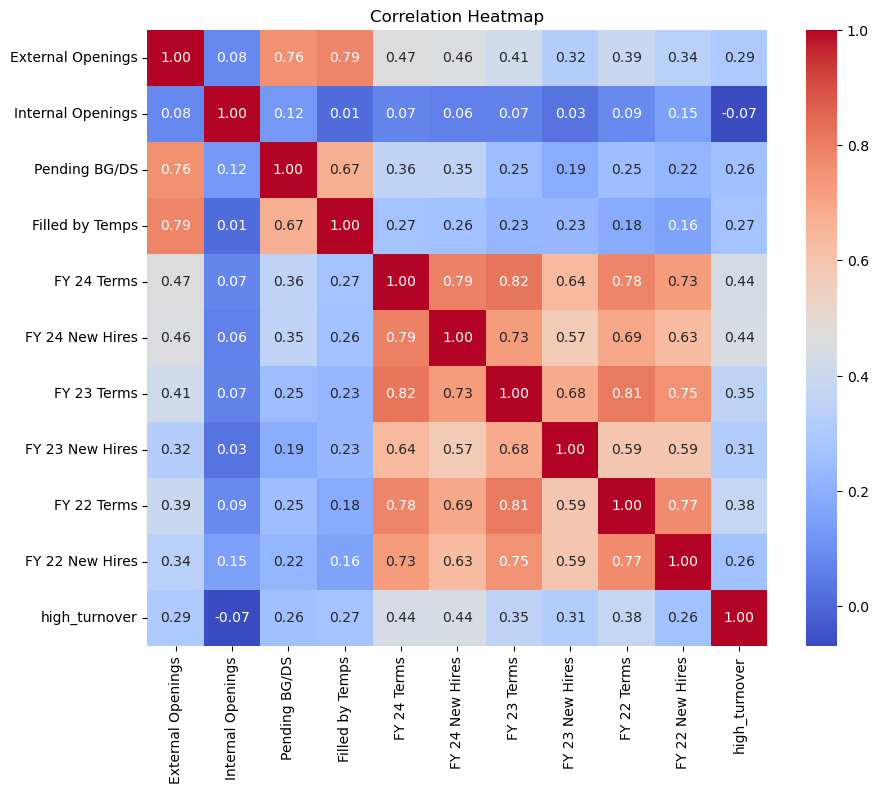

In [57]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(final_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 4. Model Building:

### I will build a logistic regression model and let's see if this data fits a good model

- A new column named training has been successfully added to final_data, with values randomly assigned as 1 and 0 in approximately a 70:30 ratio, following your instructions. The distribution of the training column confirms the split:

In [58]:
# Adding a new column 'training' to the final_data with random 1 and 0 assigned in a 70:30 ratio
np.random.seed(42)  # For reproducibility
final_data['training'] = np.random.choice([1, 0], size=len(final_data), p=[0.7, 0.3])

# Checking the distribution of the 'training' column to ensure it's approximately 70:30
training_distribution = final_data['training'].value_counts(normalize=True)
training_distribution


training
1    0.702171
0    0.297829
Name: proportion, dtype: float64

In [59]:
final_data

,External Openings,Internal Openings,Pending BG/DS,Filled by Temps,FY 24 Terms,FY 24 New Hires,FY 23 Terms,FY 23 New Hires,FY 22 Terms,FY 22 New Hires,high_turnover,training
0,31,0,6,12,7,4,9,11,11,6,1,1
1,31,0,6,12,7,22,11,13,7,6,1,0
2,31,0,6,12,11,2,12,7,14,11,1,0
3,31,0,6,12,9,6,8,14,13,7,1,1
4,31,0,6,12,5,21,10,20,6,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
31315,0,0,0,0,1,2,7,0,3,3,1,0
31316,0,0,0,0,1,1,3,4,1,3,1,1
31317,0,0,0,0,1,1,6,7,0,3,1,0
31318,0,0,0,0,2,1,0,1,0,0,1,1


In [60]:
# Clean the column names to make them more consistent and Pythonic
final_data.columns = final_data.columns.str.lower().str.replace(' ', '_')
final_data.columns = final_data.columns.str.lower().str.replace('/', '_')
# Display the cleaned column names and the first few rows to verify
final_data.head()


,external_openings,internal_openings,pending_bg_ds,filled_by_temps,fy_24_terms,fy_24_new_hires,fy_23_terms,fy_23_new_hires,fy_22_terms,fy_22_new_hires,high_turnover,training
0,31,0,6,12,7,4,9,11,11,6,1,1
1,31,0,6,12,7,22,11,13,7,6,1,0
2,31,0,6,12,11,2,12,7,14,11,1,0
3,31,0,6,12,9,6,8,14,13,7,1,1
4,31,0,6,12,5,21,10,20,6,7,1,1


In [61]:
final_data_train = final_data[final_data['training'] == 1]

lr = rsm.logistic(
    data=final_data_train, 
    rvar='high_turnover', 
    evar=[
        'external_openings', 'internal_openings', 'pending_bg_ds', 'filled_by_temps', 
        'fy_24_terms', 'fy_24_new_hires', 'fy_23_terms', 'fy_23_new_hires', 
        'fy_22_terms', 'fy_22_new_hires'
    ]
)

lr.summary()

Logistic regression (GLM)
Data                 : Not provided
Response variable    : high_turnover
Level                : None
Explanatory variables: external_openings, internal_openings, pending_bg_ds, filled_by_temps, fy_24_terms, fy_24_new_hires, fy_23_terms, fy_23_new_hires, fy_22_terms, fy_22_new_hires
Null hyp.: There is no effect of x on high_turnover
Alt. hyp.: There is an effect of x on high_turnover

                      OR     OR%  coefficient  std.error  z.value p.value     
Intercept          0.247  -75.3%        -1.40      0.026  -52.924  < .001  ***
external_openings  0.971   -2.9%        -0.03      0.010   -3.041   0.002   **
internal_openings  0.534  -46.6%        -0.63      0.034  -18.497  < .001  ***
pending_bg_ds      1.287   28.7%         0.25      0.023   10.783  < .001  ***
filled_by_temps    1.496   49.6%         0.40      0.018   22.926  < .001  ***
fy_24_terms        1.112   11.2%         0.11      0.007   15.530  < .001  ***
fy_24_new_hires    1.109   10.9% 

#### The logistic regression model's output provides several pieces of information that are useful for interpretation:

#### Odds Ratios (OR): These values indicate the change in odds for a one-unit change in the predictor variable, with all other variables held constant.
- For example, filled_by_temps has an OR of 1.496, which means that for each additional temporary worker filled, the odds of high turnover increase by about 49.6%.

#### Coefficients: These are the log-odds that correspond to the OR. Positive values indicate an increase in the log-odds of the outcome variable (high turnover) for a one-unit increase in the predictor.
- For instance, fy_24_new_hires has a coefficient of 0.10, suggesting that new hires in FY 24 slightly increase the likelihood of high turnover.

#### P-Values: These indicate the statistical significance of the coefficients. A p-value less than 0.05 typically means the effect is statistically significant.
- All listed variables have a p-value less than 0.001, meaning they are all highly significant predictors of turnover.

#### Pseudo R-squared: This is a measure of the model fit. The McFadden R-squared value of 0.263 suggests that approximately 26.3% of the variability in turnover is explained by the model.

#### AUC (Area Under the ROC Curve): The AUC of 0.81 suggests that the model has good discriminative ability to differentiate between high and low turnover cases.

None


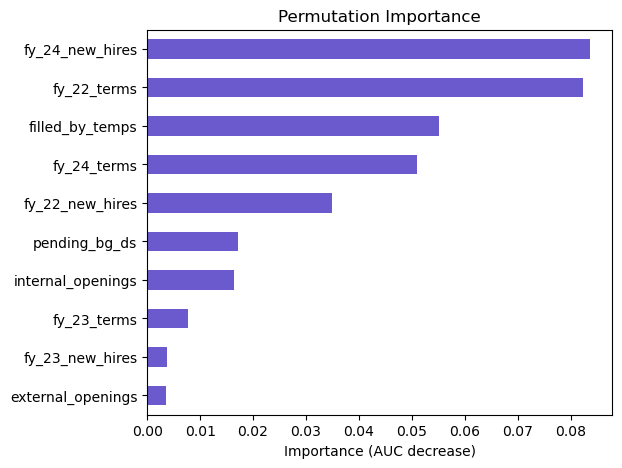

In [62]:
# Plot variable importance
print(lr.plot(plots="vimp"))


### Regarding the permutation importance plot, it shows the importance of each variable in predicting the outcome based on how much the model's performance decreases when the variable's values are randomly shuffled. This helps in understanding which variables have the most impact on the prediction.

- fy_24_new_hires seems to be the most important feature, followed by fy_22_terms and filled_by_temps. These variables have the greatest impact on the model's predictive performance.


None


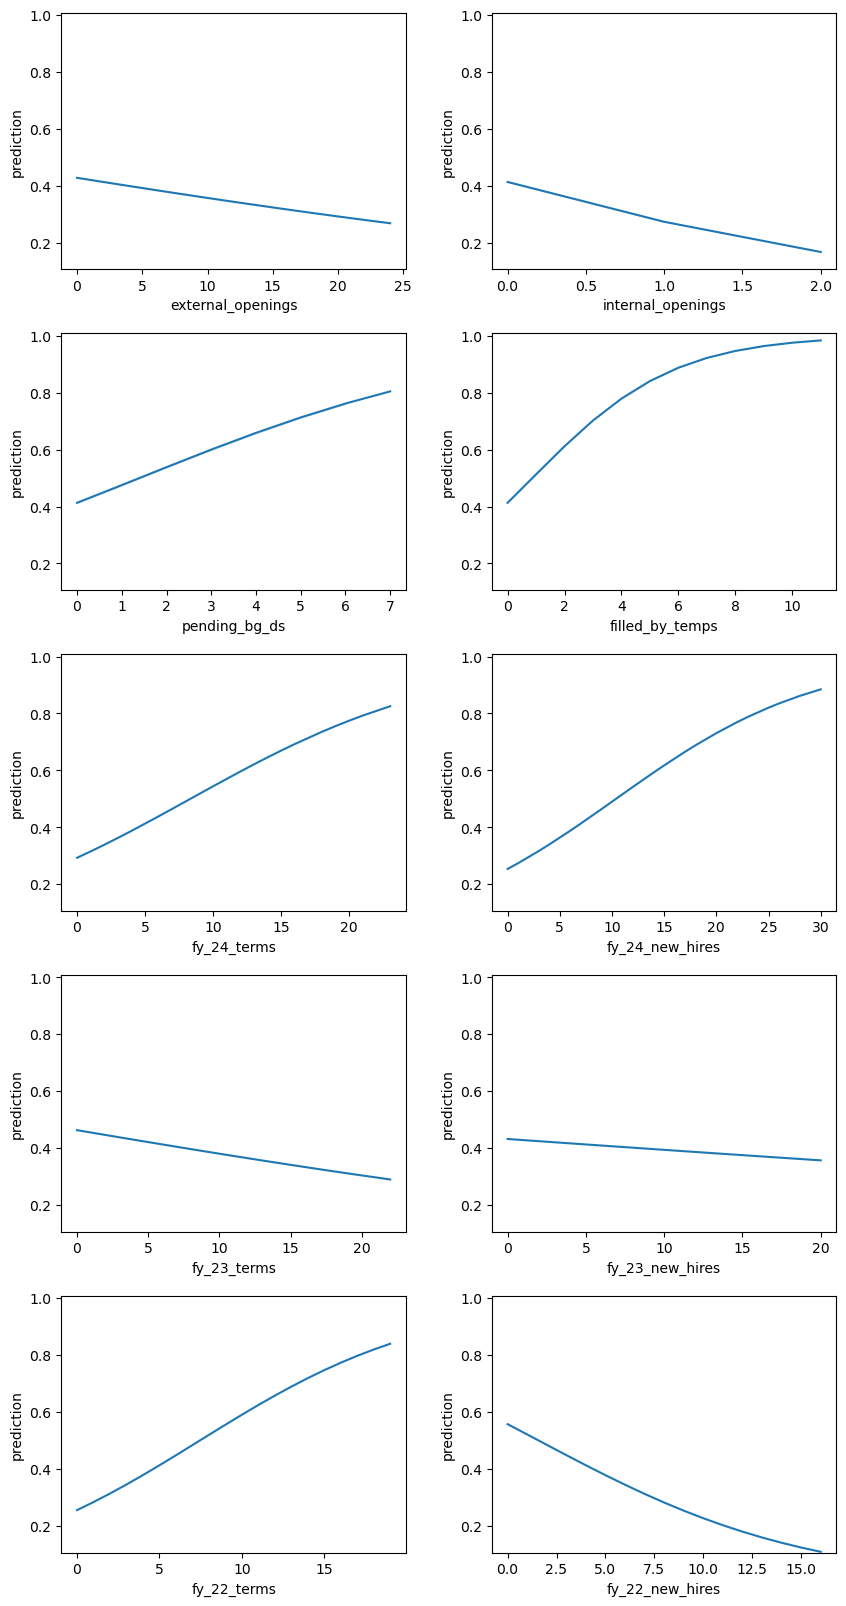

In [63]:
# Plot predictions
print(lr.plot(plots="pred", incl=['external_openings', 'internal_openings', 'pending_bg_ds', 'filled_by_temps', 
        'fy_24_terms', 'fy_24_new_hires', 'fy_23_terms', 'fy_23_new_hires', 
        'fy_22_terms', 'fy_22_new_hires']))

### For the prediction plots, they illustrate how changes in each predictor variable affect the predicted probability of high turnover. Generally, an upward slope indicates that an increase in the predictor variable is associated with higher predicted turnover, while a downward slope suggests the opposite.

### Interpretation:
- The model indicates that certain factors such as the number of new hires in a fiscal year, the number of temporary positions filled, and the terms of employment in previous fiscal years are influential in predicting high turnover rates.

- The positive coefficients for terms and new hires suggest that higher rates of hiring or terms are associated with increased turnover, potentially indicating issues such as insufficient onboarding or mismatches between job roles and hires.

- The negative coefficients for some variables suggest that they might have a stabilizing effect on turnover, meaning as these numbers increase, the likelihood of high turnover decreases.


## Based on this model, it appears that we can predict the likelihood of employee turnover within the next year to a reasonably accurate extent. Both current hiring rates (new hires in different fiscal years) and turnover rates (terms) are influential predictors. 

## With this trained model, I will go ahead and run the model to my testing data which was 30% portion of the original data. 

In [73]:
final_data_test = final_data[final_data['training'] == 0]

lr_test = rsm.logistic(
    data=final_data_test, 
    rvar='high_turnover', 
    # Now I will pick the most influencial columns that was found previously. 
    evar=[
        'fy_24_new_hires', 'filled_by_temps', 'fy_22_terms'
    ]
)

lr_test.summary()

Logistic regression (GLM)
Data                 : Not provided
Response variable    : high_turnover
Level                : None
Explanatory variables: fy_24_new_hires, filled_by_temps, fy_22_terms
Null hyp.: There is no effect of x on high_turnover
Alt. hyp.: There is an effect of x on high_turnover

                    OR     OR%  coefficient  std.error  z.value p.value     
Intercept        0.243  -75.7%        -1.41      0.037  -37.864  < .001  ***
fy_24_new_hires  1.108   10.8%         0.10      0.005   21.814  < .001  ***
filled_by_temps  1.447   44.7%         0.37      0.022   16.750  < .001  ***
fy_22_terms      1.072    7.2%         0.07      0.006   11.199  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Pseudo R-squared (McFadden): 0.208
Pseudo R-squared (McFadden adjusted): 0.207
Area under the RO Curve (AUC): 0.777
Log-likelihood: -5094.091, AIC: 10196.181, BIC: 10224.744
Chi-squared: 2672.398, df(3), p.value < 0.001 
Nr obs: 9,328


In [74]:
final_data_test

,external_openings,internal_openings,pending_bg_ds,filled_by_temps,fy_24_terms,fy_24_new_hires,fy_23_terms,fy_23_new_hires,fy_22_terms,fy_22_new_hires,high_turnover,training
1,31,0,6,12,7,22,11,13,7,6,1,0
2,31,0,6,12,11,2,12,7,14,11,1,0
7,31,0,6,12,8,17,12,10,8,11,1,0
9,31,0,6,12,7,18,8,14,5,6,1,0
11,5,0,2,0,7,22,11,13,7,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31310,0,0,0,0,5,2,5,3,0,2,1,0
31311,0,0,0,0,3,4,5,6,5,1,1,0
31314,0,0,0,0,4,0,3,1,5,4,1,0
31315,0,0,0,0,1,2,7,0,3,3,1,0


In [75]:
final_data_test['prediction_model'] = lr_test.predict()["prediction"]
final_data_test

/tmp/ipykernel_63158/380652280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_test['prediction_model'] = lr_test.predict()["prediction"]


,external_openings,internal_openings,pending_bg_ds,filled_by_temps,fy_24_terms,fy_24_new_hires,fy_23_terms,fy_23_new_hires,fy_22_terms,fy_22_new_hires,high_turnover,training,prediction_model
1,31,0,6,12,7,22,11,13,7,6,1,0,0.996834
2,31,0,6,12,11,2,12,7,14,11,1,0,0.985147
7,31,0,6,12,8,17,12,10,8,11,1,0,0.995085
9,31,0,6,12,7,18,8,14,5,6,1,0,0.994535
11,5,0,2,0,7,22,11,13,7,6,1,0,0.789496
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31310,0,0,0,0,5,2,5,3,0,2,1,0,0.229780
31311,0,0,0,0,3,4,5,6,5,1,1,0,0.341360
31314,0,0,0,0,4,0,3,1,5,4,1,0,0.256141
31315,0,0,0,0,1,2,7,0,3,3,1,0,0.268778


In [78]:
merged_data

,Report Date,Plant #,Plant Name_x,Department,External Openings,Internal Openings,Pending BG/DS,Filled by Temps,Plant Name_y,Month Year,FY 24 Terms,FY 24 New Hires,FY 23 Terms,FY 23 New Hires,FY 22 Terms,FY 22 New Hires,Plant Name,Rolling 12 Month TO%,high_turnover
0,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,April,7,4,9,11,11,6,Birmingham,0.383051,1
1,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,May,7,22,11,13,7,6,Birmingham,0.383051,1
2,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,June,11,2,12,7,14,11,Birmingham,0.383051,1
3,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,July,9,6,8,14,13,7,Birmingham,0.383051,1
4,2023-04-11,43,Birmingham,Production,31,0,6,12,Birmingham,August,5,21,10,20,6,7,Birmingham,0.383051,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31315,2024-01-23,624,Edmonton,QA,0,0,0,0,Edmonton,September,1,2,7,0,3,3,Edmonton,0.500000,1
31316,2024-01-23,624,Edmonton,QA,0,0,0,0,Edmonton,October,1,1,3,4,1,3,Edmonton,0.500000,1
31317,2024-01-23,624,Edmonton,QA,0,0,0,0,Edmonton,November,1,1,6,7,0,3,Edmonton,0.500000,1
31318,2024-01-23,624,Edmonton,QA,0,0,0,0,Edmonton,December,2,1,0,1,0,0,Edmonton,0.500000,1


In [94]:
# Step 1: Merge the tables
final_data_with_predictions = pd.merge(
    merged_data[['Plant #', 'Plant Name_x', 'Department']],
    final_data_test,
    left_on='Plant #',
    right_index=True,  
    how='inner'
)

# Selecting specific columns and renaming 'Plant Name_x' to 'Plant Name'
final_data_with_predictions = final_data_with_predictions[['Plant #', 'Plant Name_x', 'prediction_model']].copy()
final_data_with_predictions = final_data_with_predictions.rename(columns={'Plant Name_x': 'Plant Name'})

# Dropping duplicates to have unique rows
unique_data = final_data_with_predictions.drop_duplicates()
unique_data = unique_data.reset_index(drop=True)
# Displaying the first five rows of the unique_data DataFrame
unique_data

,Plant #,Plant Name,prediction_model
0,43,Birmingham,0.525928
1,34,Albert Lea,0.905305
2,86,Port St. Lucie,0.668853
3,86,Port St. Lucie,0.668853
4,33,Waukesha,0.770534
5,55,St. Joseph,0.999317
6,75,Ontario,0.799251
7,25,Chambersburg,0.852053


/tmp/ipykernel_63158/969007113.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Plant Name', y='prediction_model', data=unique_data, palette=colors)
/tmp/ipykernel_63158/969007113.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}%'.format(y*100) for y in ax.get_yticks()])


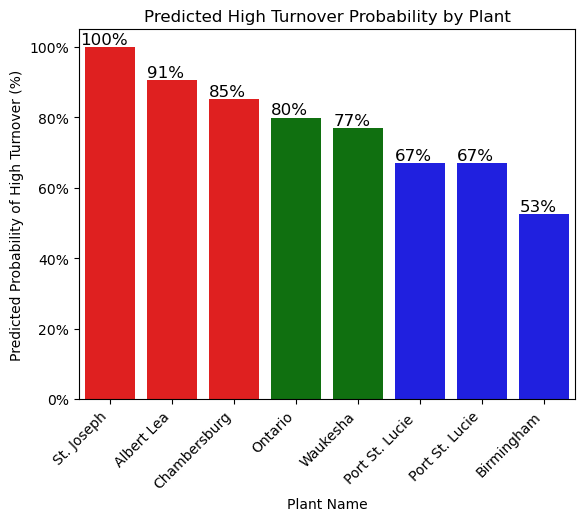

In [93]:
# Sort the data
unique_data = unique_data.sort_values('prediction_model', ascending=False)

# Create a color list
colors = ['red' if x < 3 else 'green' if x < 5 else 'blue' for x in range(unique_data.shape[0])]

# Create the barplot
ax = sns.barplot(x='Plant Name', y='prediction_model', data=unique_data, palette=colors)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Change y-axis to percentage
ax.set_yticklabels(['{:.0f}%'.format(y*100) for y in ax.get_yticks()])

# Add labels on top of bars
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(p.get_height()*100), (p.get_x()+0.3, p.get_height()),
                ha='center', va='bottom', color='black', size=12)

# Set labels and title
plt.xlabel('Plant Name')
plt.ylabel('Predicted Probability of High Turnover (%)')
plt.title('Predicted High Turnover Probability by Plant')

plt.show()


# 5. Interpretation and Conclusion:

### Interpretation:
- A higher value in the prediction_model column indicates a higher probability of turnover within the next year. 

### Meaning for Each Branch:
- St. Joseph has the highest predicted probability (nearly 1), which suggests it is very likely to experience high turnover.
- Albert Lea, with a probability of around 0.91, is at high risk.
- Birmingham, with a probability of approximately 0.53, has a moderate risk of turnover.
- Port St. Lucie shows a risk that is higher than Birmingham but lower than Albert Lea.
- Waukesha, Ontario, and Chambersburg are also at a higher risk, with probabilities ranging from 0.77 to 0.85.


### Analysis for Management:
- The analysis indicates varying risks of turnover across different plants.
- Plants with high probabilities, especially those close to 1, should be a focus for management as they are indicative of potential underlying issues that could be driving employees to leave.

### Recommendations for High Turnover Rates:
- For plants like Albert Lea and St. Joseph, HR management could investigate specific causes of turnover. This might include job satisfaction surveys, exit interviews, and reviewing working conditions or compensation levels.


## This analysis aims to provide insights into which plants may need targeted interventions to reduce turnover. Each plant's situation will be unique, and the strategies should be tailored to address the specific challenges and factors contributing to its turnover rate. Management should prioritize resources and interventions where they're most needed, as indicated by the model's predictions.
